In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

iris = load_iris()
X = iris.data[:, 2:] # Petal length and width
y = iris['target']

## Classification

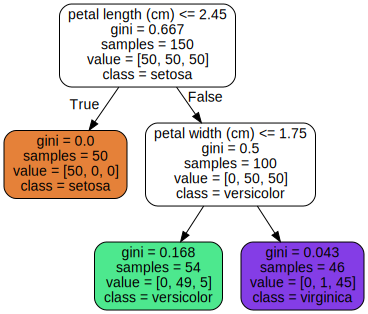

In [ ]:
import graphviz

tree_clf = DecisionTreeClassifier(max_depth=2).fit(X, y)

export_graphviz(
    tree_clf,
    out_file='./iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

graphviz.Source.from_file('./iris_tree.dot')

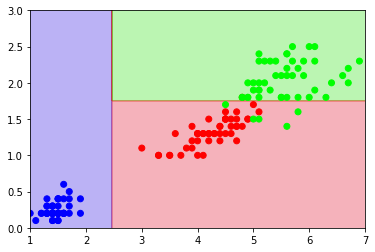

In [ ]:
def plot_predict_proba(clf, axes, *args, **kwargs):
    x0s = np.linspace(axes[0], axes[1], 200)
    x1s = np.linspace(axes[2], axes[3], 200)

    x0, x1 = np.meshgrid(x0s, x1s)
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_pred_proba = clf.predict(X_new).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred_proba, cmap=plt.cm.brg, alpha=0.3)

plot_predict_proba(tree_clf, [1, 7, 0, 3])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.brg)
plt.show()

## Regression

In [ ]:
X = np.random.rand(100)
y = 2 * X**2 - 2 * X + 0.5 + np.random.rand(100) / 5
X = X.reshape(-1, 1)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor().fit(X, y)
tree_reg_regular = DecisionTreeRegressor(max_depth=4).fit(X, y)

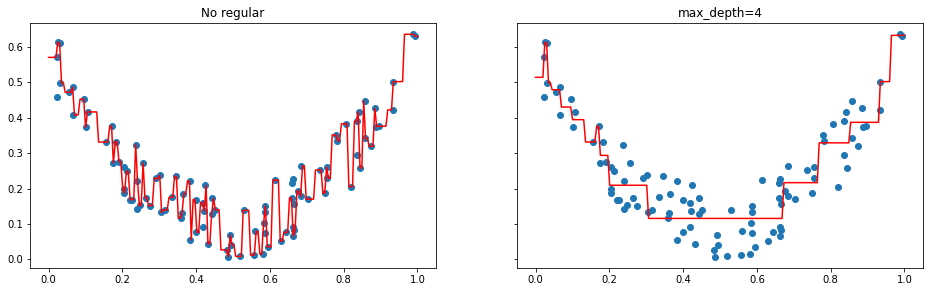

In [ ]:
def plot_regressor(clf, x_min, x_max, *args, **kwargs):
    X = np.linspace(x_min, x_max, 200).reshape(-1, 1)
    y = clf.predict(X)
    plt.plot(X, y, *args, **kwargs)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16, 4.5))

plt.sca(axs[0])
plt.title('No regular')
plt.scatter(X, y)
plot_regressor(tree_reg, 0, 1, c='red')

plt.sca(axs[1])
plt.title('max_depth=4')
plot_regressor(tree_reg_regular, 0, 1, c='red')
plt.scatter(X, y)

plt.show()

## Exercises

#### Fine tuning

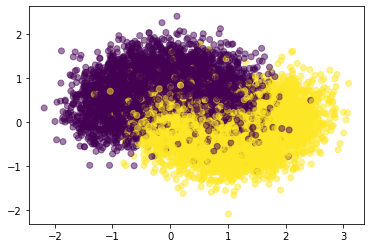

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=10000, noise=0.4)

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
plt.show()

In [5]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': np.arange(5, 105, 5),
    'min_samples_leaf': np.arange(5, 200, 15),
}
grid_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy', n_jobs=-1, cv=3, return_train_score=True)
grid_cv.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [6]:
import pandas as pd

cv_results = grid_cv.cv_results_
cv_results_df = pd.concat([
    pd.DataFrame(cv_results['params']),                
    pd.DataFrame(cv_results['mean_test_score'], columns=['mean_test_score']),
    pd.DataFrame(cv_results['std_test_score'], columns=['std_test_score']),
    pd.DataFrame(cv_results['mean_train_score'], columns=['mean_train_score']),
], axis=1)

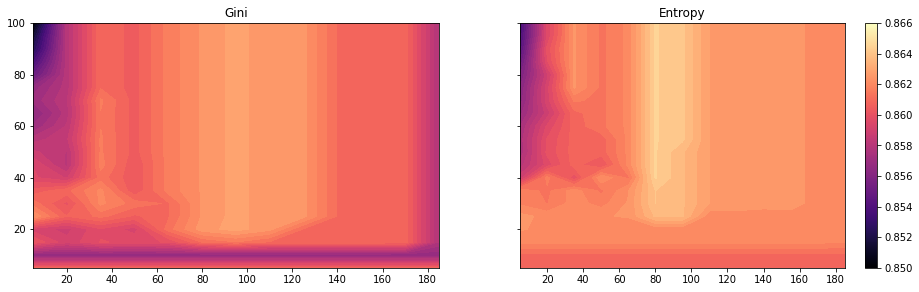

In [12]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(16, 4.5))
levels = np.linspace(0.85, 0.868, 40)

def plot_cv_results(df):
    df = df.sort_values(['max_leaf_nodes', 'min_samples_leaf'])

    x0 = gini_df['min_samples_leaf'].unique()
    x1 = gini_df['max_leaf_nodes'].unique()


    y = df['mean_test_score'].to_numpy().reshape(x1.shape[0], x0.shape[0])

    plt.contourf(x0, x1, y, levels=levels, cmap='magma')

plt.sca(axs[0])
plt.title('Gini')
gini_df = cv_results_df.query('criterion == "gini"')
plot_cv_results(gini_df)

plt.sca(axs[1])
plt.title('Entropy')
entropy_df = cv_results_df.query('criterion == "entropy"')
plot_cv_results(entropy_df)

fig.colorbar(ScalarMappable(Normalize(vmin=0.85, vmax=0.866), cmap='magma'))
fig.show()

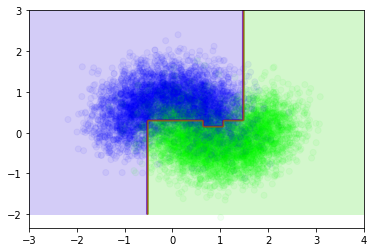

Accuracy:  0.8691


In [13]:
from sklearn.metrics import accuracy_score
tree_clf = grid_cv.best_estimator_

def plot_clf(clf, axes):
    x0 = np.linspace(axes[0], axes[1], 200)
    x1 = np.linspace(axes[2], axes[3], 200)
    xx, yy = np.meshgrid(x0, x1)

    X_new = np.c_[xx.ravel(), yy.ravel()]
    y_pred = clf.predict(X_new).reshape(xx.shape)

    plt.contour(xx, yy, y_pred, cmap='brg', alpha=0.3)
    plt.contourf(xx, yy, y_pred, cmap='brg', alpha=0.2)

plot_clf(tree_clf, [-3, 4, -2, 3])
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.05, cmap='brg')

plt.show()

print('Accuracy: ', accuracy_score(y, tree_clf.predict(X)))

#### Forest

In [15]:
from sklearn.base import clone
from scipy.stats import mode
from sklearn.model_selection import ShuffleSplit

class CustomRandomForestClassifier:
    def __init__(self, base_classifier, n_estimators=1000, instances_per_estimator=1, random_state=0):
        self.n_estimators = n_estimators
        self.estimators = [clone(base_classifier) for _ in range(n_estimators)]
        self.instances_per_estimator = instances_per_estimator
        self.random_state = random_state

    def fit(self, X, y):
        X = self._transform_input(X)
        rs = ShuffleSplit(n_splits=self.n_estimators, random_state=self.random_state, train_size=self.instances_per_estimator)

        for estimator, (train_indexes, _ ) in zip(self.estimators, rs.split(X)):
            estimator.fit(X[train_indexes], y[train_indexes])

        return self

    def predict_proba(self, X):
        X = self._transform_input(X)

        predictions = [estimator.predict(X).reshape(-1, ) for estimator in self.estimators]
        predictions = np.array(predictions).T

        return mode(predictions, axis=1)
    
    def predict(self, X):
        modes = self.predict_proba(X)

        return modes.mode

    def _transform_input(self, X):
        if X.ndim == 1:
            return X.reshape(1, -1)
        elif X.ndim == 2:
            return X
        else:
            raise Exeption('Invalid X shape')

forest_clf = CustomRandomForestClassifier(tree_clf, n_estimators=1000, instances_per_estimator=500, random_state=42).fit(X, y)
print('Accuracy: ', accuracy_score(y, forest_clf.predict(X)))

Accuracy:  0.7857
